In [1]:
import itertools
import logging
import os
import pickle
import textwrap
import traceback
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import librosa
import numpy as np
from tqdm import tqdm

USE_GPU = False

if USE_GPU:
    import manage_gpus as gpl

    gpl.get_gpu_lock()
import activation_learner
import pytorch_nmf
import param_estimator
import plot
from mixes.unmixdb import UnmixDB
from mixes.synthetic import SyntheticDB

In [2]:
# UNMIXDB_PATH = Path("/data2/anasynth_nonbp/andre/unmixdb-zenodo")
UNMIXDB_PATH = Path("/data2/anasynth_nonbp/schwarz/abc-dj/data/unmixdb-zenodo/")
# dataset = UnmixDB(UNMIXDB_PATH)
dataset = SyntheticDB()
GAIN_ESTOR = param_estimator.GainEstimator.SUM
WARP_ESTOR = param_estimator.WarpEstimator.CENTER_OF_MASS
LOG_NMF_EVERY = 100
DLOSS_MIN = -np.inf
ITER_MAX = 500
FS = 22050
MIX_NAME = "stretch"


logger = logging.getLogger(MIX_NAME)
logging.basicConfig()
logger.setLevel(logging.DEBUG)

mix = dataset.get_mix(MIX_NAME)
inputs = [track.audio for track in mix.tracks] + [mix.audio]

INFO:stretch:Starting round with hop_size=0.1s, win_size=0.4s
100%|██████████| 500/500 [00:04<00:00, 108.97it/s]


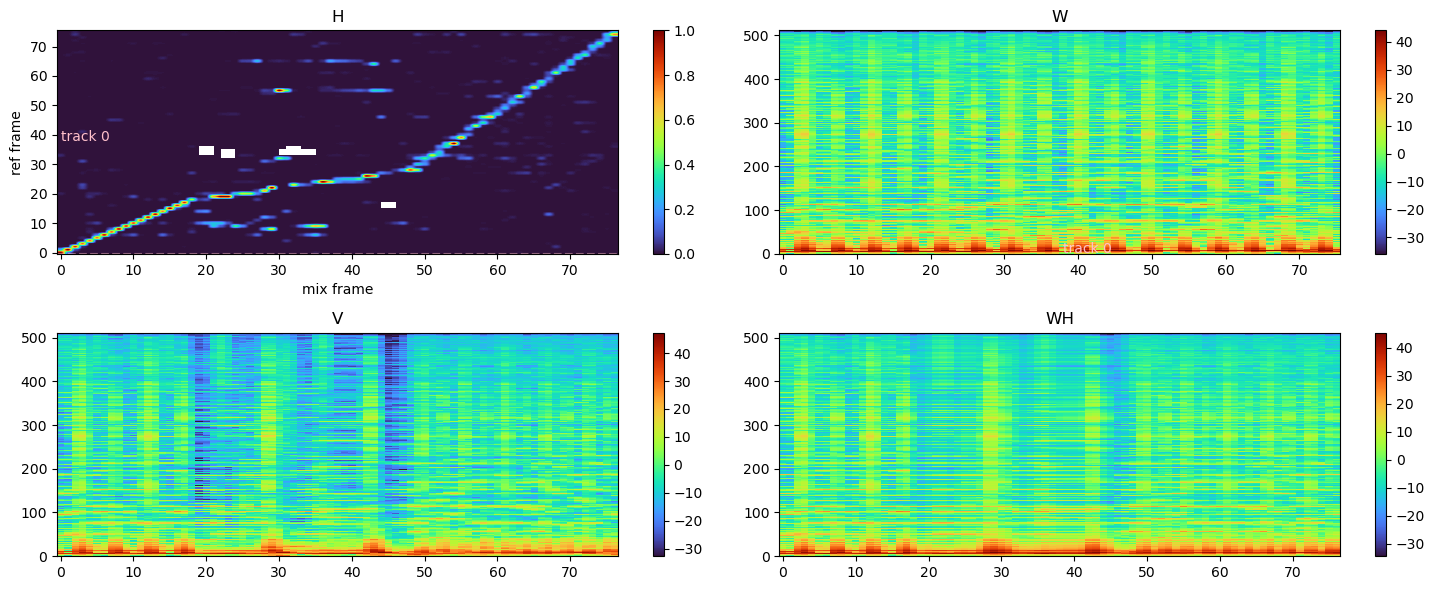

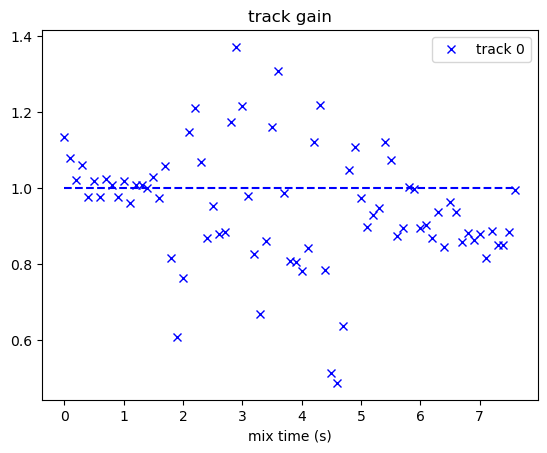

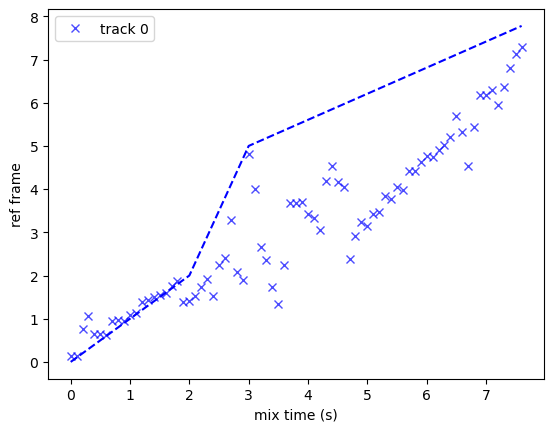

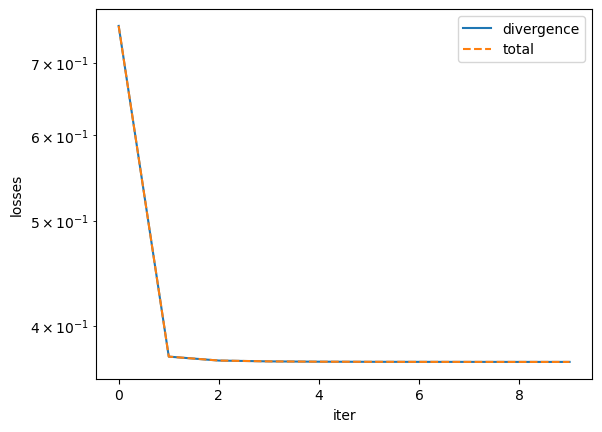

In [3]:
hop_size = 0.1

overlap = 4
win_size = hop_size * overlap
nmels = 512
low_power_threshold = 0.1
divergence = pytorch_nmf.Beta()
penalties = []

logger.info(f"Starting round with {hop_size=}s, {win_size=}s")

learner = activation_learner.ActivationLearner(
    inputs,
    fs=FS,
    n_mels=nmels,
    win_size=win_size,
    hop_size=hop_size,
    penalties=penalties,
    divergence=divergence,
    low_power_threshold=low_power_threshold,
    use_gpu=USE_GPU,
)
loss_history = learner.fit(500)
#############
# estimations

# get ground truth
tau = np.arange(0, learner.V.shape[1]) * hop_size
real_gain = mix.gain(tau)
real_warp = mix.warp(tau)

# estimate gain
est_gain = GAIN_ESTOR(learner)
err_gain = param_estimator.error(est_gain, real_gain)

# estimate warp
est_warp = WARP_ESTOR(learner, hop_size)
err_warp = param_estimator.error(est_warp, real_warp)

###################
# plots
plot.plot_nmf(learner)
plt.show()

fig = plt.figure()
plot.plot_gain(tau, est_gain, real_gain)
plt.show()

fig = plt.figure()
plot.plot_warp(tau, est_warp, real_warp)
plt.show()
fig = plt.figure()
plot.plot_loss_history(loss_history)
plt.show()

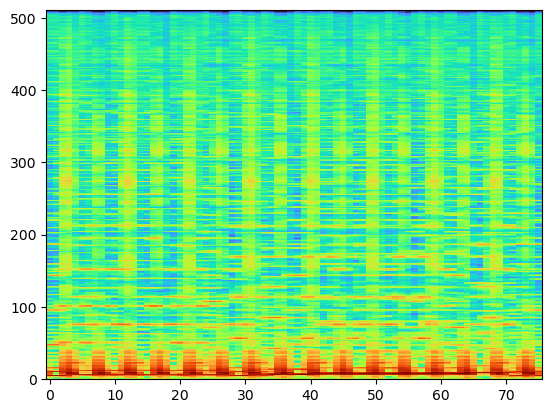

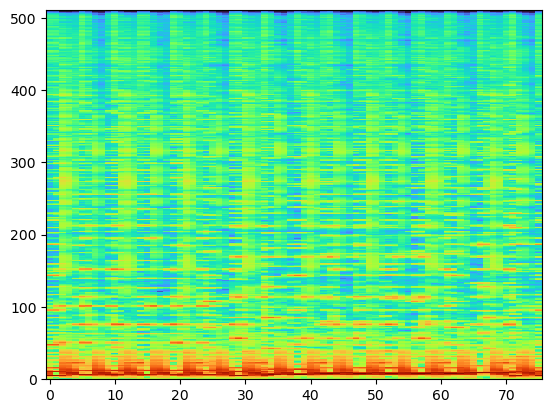

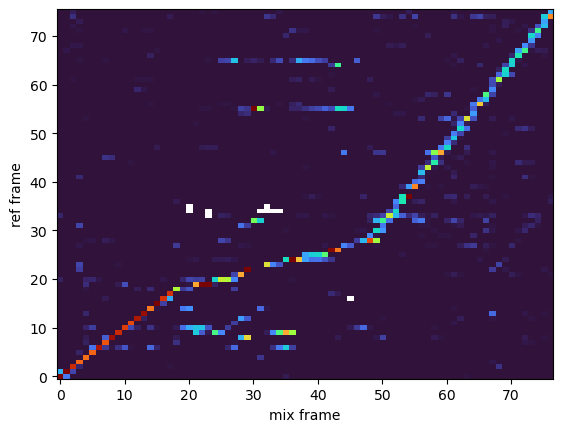

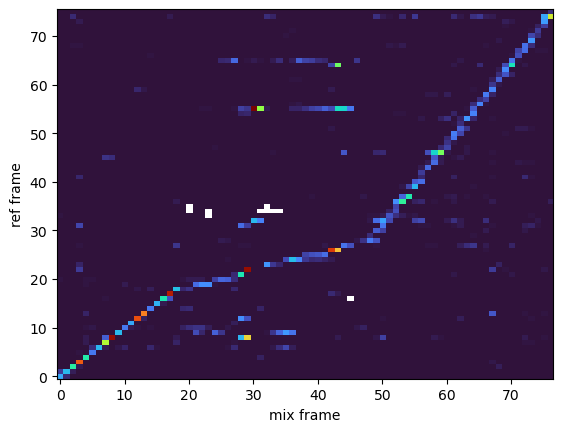

In [4]:
plot.plot_pow_spec(learner.W)
plt.show()
plot.plot_pow_spec(learner.nmf.W.detach().numpy())
plt.show()
plot.plot_H(learner.H)
plt.show()
plot.plot_H(learner.nmf.H.detach().numpy())
plt.show()